#Mengimport Library

In [1]:
import re
import string
from collections import Counter
from io import StringIO
import requests
import json

# Data Handling & Visualization
import pandas as pd
from pandas.errors import ParserError
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from wordcloud import WordCloud

# Machine Learning & Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning (TensorFlow / Keras)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Layer
from tensorflow.keras.models import Model

# Natural Language Processing (NLTK)
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag

# Unduh resource NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Memuat Data Hasil Scraping

In [2]:
df = pd.read_csv("data_merge.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7080 entries, 0 to 7079
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   7080 non-null   object
 1   Label   7080 non-null   object
dtypes: object(2)
memory usage: 110.8+ KB


In [4]:
df.head()

,Tweet,Label
0,pagi2 udah di buat emosi :),Anger
1,"kok stabilitas negara, memange 10 thn negara t...",Anger
2,dah lah emosi mulu liat emyu,Anger
3,"aib? bodoh benar! sebelum kata aib itu muncul,...",Anger
4,dih lu yg nyebelin bego,Anger


#Preprocessing

Mengecek dan Menghapus Missing Value

In [5]:
df.isna().sum()

,0
Tweet,0
Label,0


Mengecek Duplikasi Data

In [6]:
df.duplicated().sum()

np.int64(52)

In [7]:
df = df.drop_duplicates().reset_index(drop=True)

Mengecek Persebaran Kata

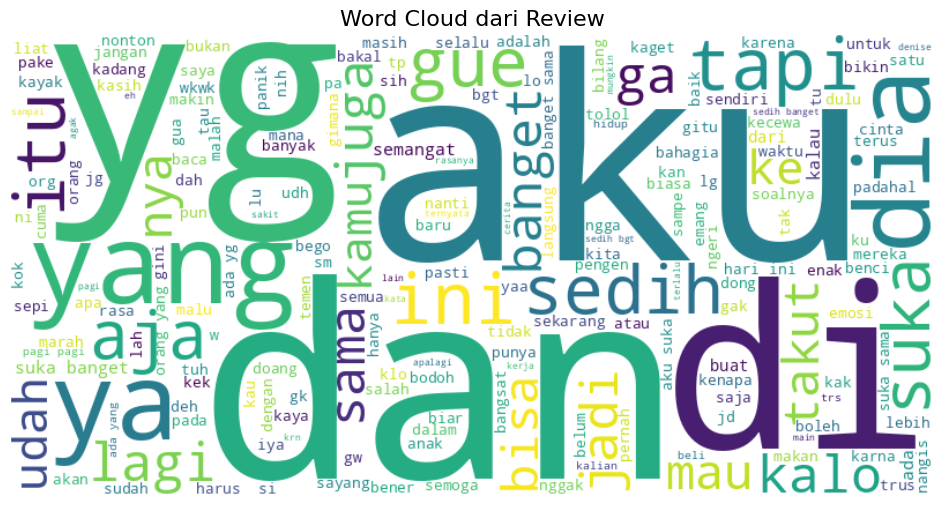

In [8]:
all_words = ' '.join(df['Tweet'])

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate(all_words)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud dari Review', fontsize=16)
plt.show()

### Text Cleaning Pipeline

Pipeline ini bertujuan untuk membersihkan dan menyiapkan data dengan menghilangkan simbol, angka, dan tautan Selain itu, mengoreksi kata slang menjadi bentuk formal menggunakan kamus eksternal; menghapus stopwords yang tidak bermakna penting; serta melakukan lemmatisasi berdasarkan jenis katanya. Dengan egitu, data teks menjadi lebih bersih dan terstruktur.

In [9]:
def get_slang_word_list(url):
    response = requests.get(url)
    lines = response.text.strip().split('\n')
    slang_dict = {}
    for line in lines:
        if '=' in line:
            key, val = line.split('=', 1)
            slang_dict[key.strip()] = val.strip()
    return slang_dict

def get_stopwords(urls):
    all_stopwords = set()
    for url in urls:
        response = requests.get(url)
        words = response.text.strip().split('\n')

        if words and 'stopword' in words[0].lower():
            words.pop(0)
        all_stopwords.update(w.strip().lower() for w in words)
    return all_stopwords

def build_slang_dictionary():
    slang_url = 'https://raw.githubusercontent.com/King-srt/Indonesia-Slang-Dictionary/refs/heads/main/dictionary_indonesia.txt'
    slangwords = get_slang_word_list(slang_url)

    with open('custom_slang.json', 'r', encoding='utf-8') as f:
        custom_slang = json.load(f)

    slangwords.update(custom_slang)
    return slangwords

import json
import requests

def get_stopwords(urls):
    stop_words = set()
    for url in urls:
        response = requests.get(url)
        if response.status_code == 200:
            lines = response.text.splitlines()
            stop_words.update([line.strip() for line in lines if line.strip()])
        else:
            print(f"Gagal mengambil data dari {url}")
    return stop_words

def build_stopwords():
    urls = [
        'https://raw.githubusercontent.com/yasirutomo/python-sentianalysis-id/master/data/feature_list/stopwordsID.txt',
        'https://raw.githubusercontent.com/Braincore-id/IndoTWEEST/main/stopwords_twitter.csv'
    ]
    stop_words = get_stopwords(urls)

    with open('add_stopwords.json', 'r', encoding='utf-8') as f:
        add_stopwords = json.load(f)

    stop_words.update(add_stopwords)

    return stop_words

def processing_text_id(text, slangwords, stop_words):
    if pd.isnull(text):
        return []

    text = text.lower()
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()

    tokens = word_tokenize(text)
    tokens = [slangwords.get(token, token) for token in tokens]
    tokens = [token for token in tokens if token not in stop_words and token.strip()]

    return tokens

In [10]:
slangwords = build_slang_dictionary()
stop_words = build_stopwords()

df_clean = df.copy()
df_clean['Review_Tokenized'] = df_clean['Tweet'].apply(
    lambda x: processing_text_id(x, slangwords, stop_words)
)
df_clean['Review_Final'] = df_clean['Review_Tokenized'].apply(lambda x: ' '.join(x))
df_clean = df_clean[df_clean['Review_Final'].str.strip() != '']
df_clean.reset_index(drop=True, inplace=True)

In [11]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6993 entries, 0 to 6992
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Tweet             6993 non-null   object
 1   Label             6993 non-null   object
 2   Review_Tokenized  6993 non-null   object
 3   Review_Final      6993 non-null   object
dtypes: object(4)
memory usage: 218.7+ KB


In [12]:
df_clean.head()

,Tweet,Label,Review_Tokenized,Review_Final
0,pagi2 udah di buat emosi :),Anger,[emosi],emosi
1,"kok stabilitas negara, memange 10 thn negara t...",Anger,"[stabilitas, negara, memange, negara, aman, sb...",stabilitas negara memange negara aman sby meny...
2,dah lah emosi mulu liat emyu,Anger,"[emosi, liat, emyu]",emosi liat emyu
3,"aib? bodoh benar! sebelum kata aib itu muncul,...",Anger,"[aib, bodoh, aib, muncul, tindakan, kekejian, ...",aib bodoh aib muncul tindakan kekejian kau sem...
4,dih lu yg nyebelin bego,Anger,"[nyebelin, bego]",nyebelin bego


### Distribusi Sentimen Berdasarkan Metode Analisis

<ipython-input-13-1021591062>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=df_clean, palette='viridis')


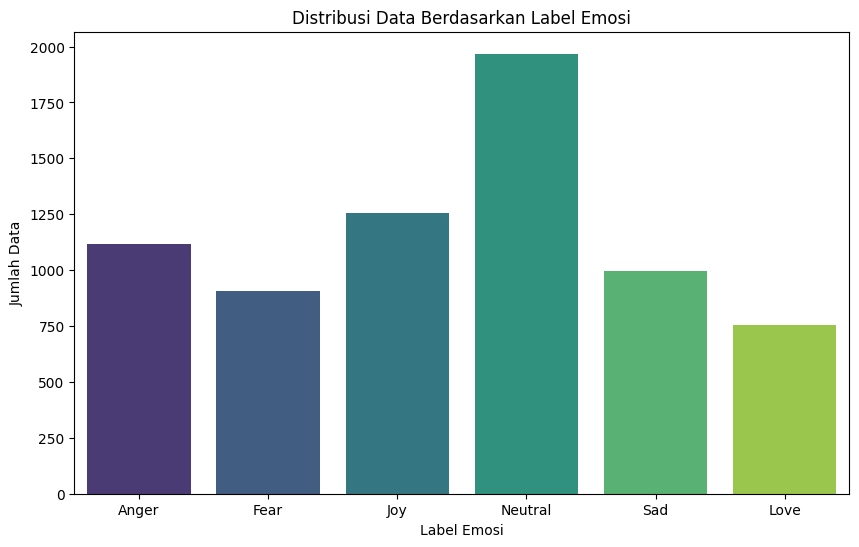

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Label', data=df_clean, palette='viridis')
plt.title('Distribusi Data Berdasarkan Label Emosi')
plt.xlabel('Label Emosi')
plt.ylabel('Jumlah Data')
plt.show()

In [14]:
df_netral = df_clean[df_clean['Label'] == 'Neutral'].copy()
netral_count = len(df_netral)

df_balanced_list = [df_netral]

for label in df_clean['Label'].unique():
    if label != 'Neutral':
        df_class = df_clean[df_clean['Label'] == label].copy()
        df_upsampled = resample(
            df_class,
            replace=True,
            n_samples=netral_count,
            random_state=42
        )
        df_balanced_list.append(df_upsampled)

df_balanced = pd.concat(df_balanced_list).sample(frac=1, random_state=42).reset_index(drop=True)

print(df_balanced['Label'].value_counts())

Label
Sad        1968
Anger      1968
Love       1968
Joy        1968
Fear       1968
Neutral    1968
Name: count, dtype: int64


### Explorasi Kata yang Sering Muncul

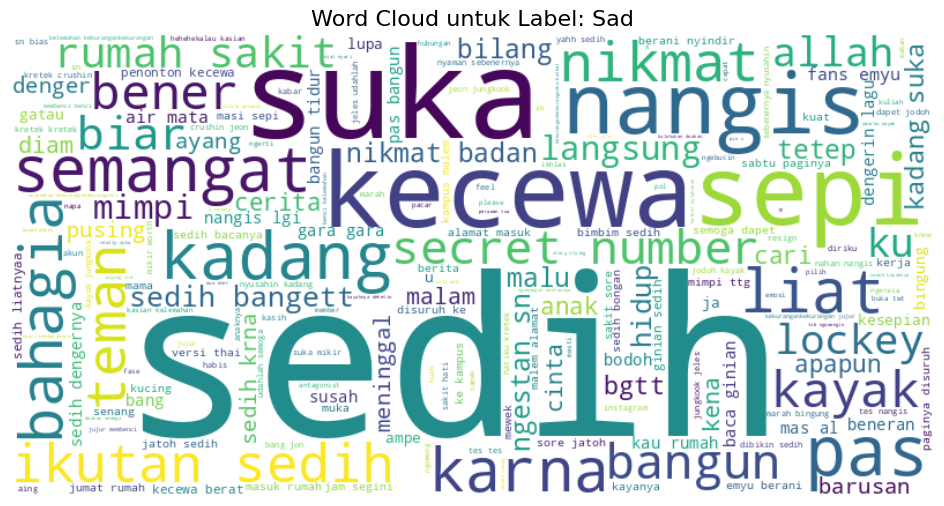

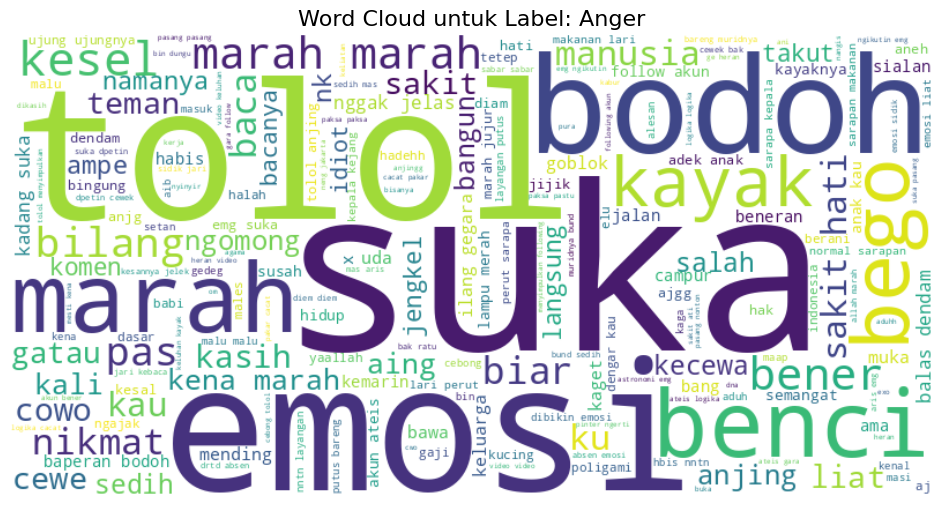

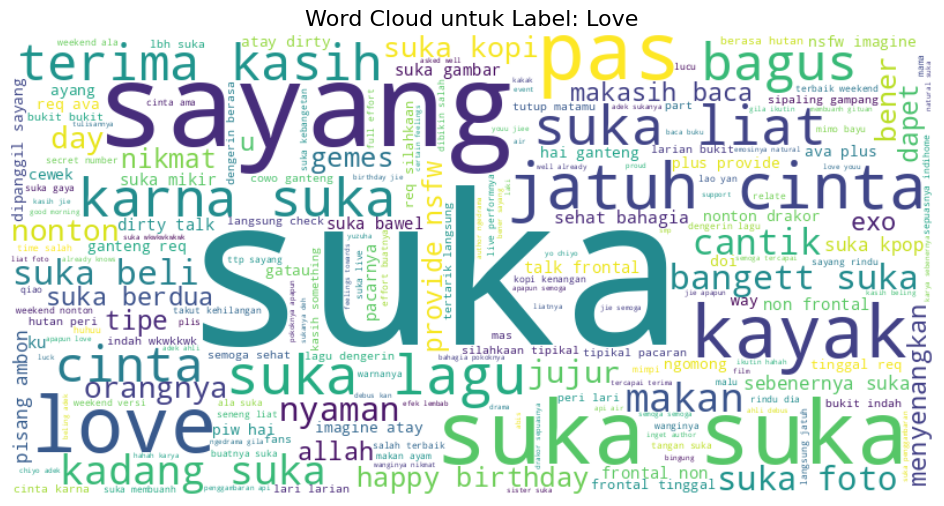

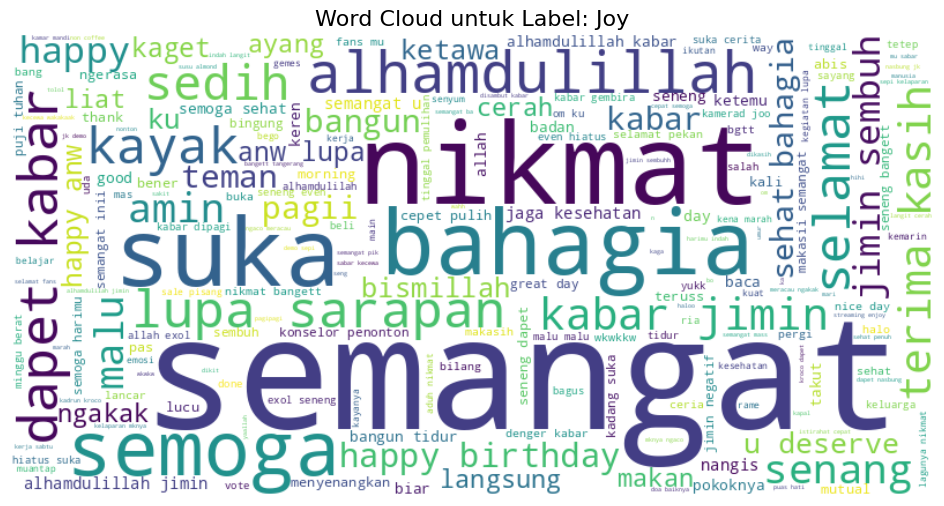

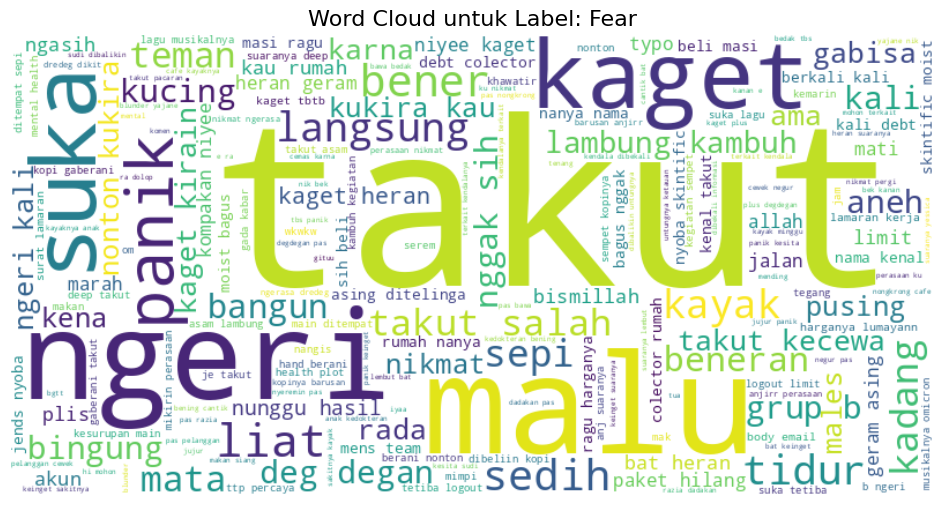

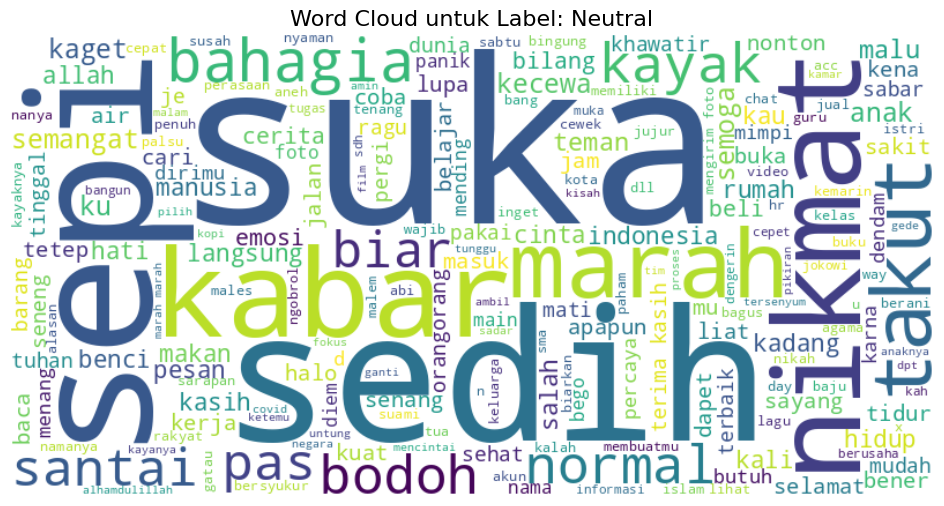

In [15]:
labels = df_balanced['Label'].unique()

for label in labels:
    df_label = df_balanced[df_balanced['Label'] == label].copy()
    text_label = ' '.join(df_label['Review_Final'])

    wordcloud_label = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        max_words=200
    ).generate(text_label)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud_label, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud untuk Label: {label}', fontsize=16)
    plt.show()

### Modeling Menggunakan LTSM dan Arsitektur Tensorflow

In [16]:
# --- Attention Layer ---
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                 initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer="zeros", trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer="glorot_uniform", trainable=True)

    def call(self, inputs):
        u_t = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        score = tf.nn.softmax(tf.tensordot(u_t, self.u, axes=1), axis=1)
        context = tf.reduce_sum(inputs * score, axis=1)
        return context

# --- Build Model ---
def build_custom_text_classifier(vocab_size, max_len, embedding_dim=500, lstm_units=128, num_classes=3):
    inputs = Input(shape=(max_len,))
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)
    x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    x = AttentionLayer()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# --- Parameter ---
max_len = 20
vocab_size = 5000

# --- Tokenisasi dan Padding ---
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df_balanced['Review_Final'])
sequences = tokenizer.texts_to_sequences(df_balanced['Review_Final'])
padded = pad_sequences(sequences, maxlen=max_len, padding='post')

# --- Label Encoding dan One-hot ---
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(df_balanced['Label'])
one_hot_labels = to_categorical(integer_labels)

# --- Split Data ---
X_train, X_test, y_train, y_test = train_test_split(padded, one_hot_labels, test_size=0.3, stratify=integer_labels, random_state=42)

# --- Hitung Class Weights ---
class_weights_raw = compute_class_weight(class_weight='balanced', classes=np.unique(integer_labels), y=integer_labels)
class_weight_dict = dict(enumerate(class_weights_raw))
class_weight_dict[0] = 1.18
class_weight_dict[4] = 0.62
class_weight_dict[5] = 1.18
# --- Build dan Compile Model ---
model = build_custom_text_classifier(vocab_size=vocab_size, max_len=max_len, num_classes=one_hot_labels.shape[1])
model.summary()

# --- Callbacks ---
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# --- Training ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=16,
    class_weight=class_weight_dict,
    callbacks=[early_stop, model_checkpoint]
)

# --- Evaluasi ---
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 20, 500)        │     2,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 20, 256)        │       644,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 256)            │        66,048 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,211,686 (12.25 MB)

 Trainable params: 3,211,686 (12.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
516/517 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5256 - loss: 1.2202

517/517 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.5261 - loss: 1.2190 - val_accuracy: 0.7931 - val_loss: 0.6514
Epoch 2/20
513/517 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8517 - loss: 0.3953

517/517 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8518 - loss: 0.3950 - val_accuracy: 0.8089 - val_loss: 0.6240
Epoch 3/20
515/517 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9252 - loss: 0.1982

517/517 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9252 - loss: 0.1983 - val_accuracy: 0.8315 - val_loss: 0.6222
Epoch 4/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9460 - loss: 0.1458 - val_accuracy: 0.8363 - val_loss: 0.6658
Epoch 5/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9673 - loss: 0.0991 - val_accuracy: 0.8394 - val_loss: 0.7065
Epoch 6/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9640 - loss: 0.1070 - val_accuracy: 0.8329 - val_loss: 0.7772
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

       Anger       0.84      0.89      0.86       590
        Fear       0.86      0.92      0.89       590
         Joy       0.84      0.85      0.84       591
        Love       0.87      0.93      0.90       591
     Neutral       0.72      0.50      0.59       591
         Sad       0.82      0.90      0.86       590

    accuracy                           0.83      3543
   macro avg     

Save tokenizer dan label encoder

In [17]:

tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [18]:
import pickle

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

Hasil Prediksi Model

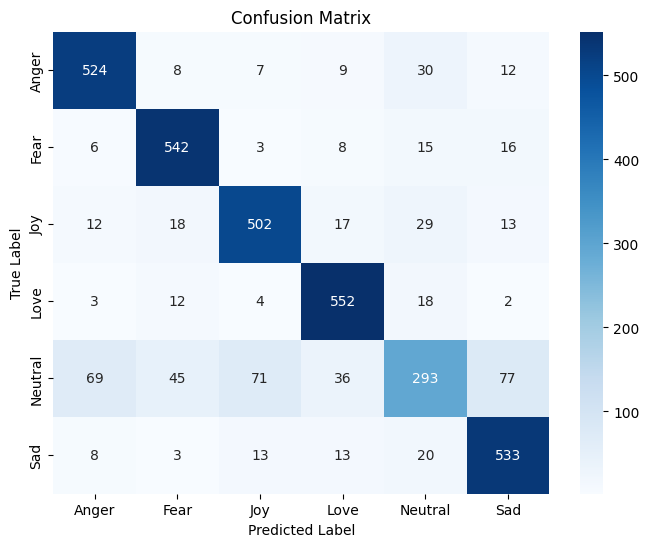

In [19]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Inference Sederhana

In [20]:
def predict_sentiment_per_sentence(text, model, tokenizer, label_encoder, max_len, slangwords, stop_words):

    sentences = sent_tokenize(text)
    results = []

    for sentence in sentences:
        cleaned_tokens = processing_text_id(sentence, slangwords, stop_words)
        processed_text = ' '.join(cleaned_tokens)

        sequence = tokenizer.texts_to_sequences([processed_text])
        padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post')

        prediction = model.predict(padded_sequence, verbose=0)
        predicted_class_index = np.argmax(prediction, axis=1)[0]
        predicted_label = label_encoder.inverse_transform([predicted_class_index])[0]

        results.append((sentence, predicted_label))

    return results

In [21]:
contoh_teks = """
hari ini tuh rasanya bener² berat. dari pagi udah banyak banget tugas numpuk,
trus ditambah dosen tiba² ngasih deadline mepet. pengen nangis aja asli, tapi nahan terus.
ga tau ya, kadang mikir, ini semua bakal worth it gak sih? temen² juga lagi sibuk semua,
jadi ngerasa sendiri banget. pengen cerita tapi takut ganggu orang.
"""
hasil = predict_sentiment_per_sentence(
    contoh_teks,
    model=model,
    tokenizer=tokenizer,
    label_encoder=label_encoder,
    max_len=max_len,
    slangwords=slangwords,
    stop_words=stop_words
)

for kalimat, label in hasil:
    print(f"Kalimat: {kalimat.strip()}")
    print(f"Prediksi Sentimen: {label}")
    print("-" * 50)



Kalimat: hari ini tuh rasanya bener² berat.
Prediksi Sentimen: Anger
--------------------------------------------------
Kalimat: dari pagi udah banyak banget tugas numpuk,
trus ditambah dosen tiba² ngasih deadline mepet.
Prediksi Sentimen: Neutral
--------------------------------------------------
Kalimat: pengen nangis aja asli, tapi nahan terus.
Prediksi Sentimen: Sad
--------------------------------------------------
Kalimat: ga tau ya, kadang mikir, ini semua bakal worth it gak sih?
Prediksi Sentimen: Sad
--------------------------------------------------
Kalimat: temen² juga lagi sibuk semua,
jadi ngerasa sendiri banget.
Prediksi Sentimen: Neutral
--------------------------------------------------
Kalimat: pengen cerita tapi takut ganggu orang.
Prediksi Sentimen: Fear
--------------------------------------------------


In [22]:
contoh_teks = """
hari ini tuh bener² aneh... dari pagi udah badmood gara² alarm gak bunyi, telat ngampus, trus pas presentasi malah file-nya korup. udah gitu temen² juga pada sibuk sendiri, ngerasa invisible aja gitu hari ini. cape banget sumpah.

ih pokoknya benci banget deh. akutuh gasuka digituin. aku kesel deh sama dia. hari ini biasa aja sih. gaada yang spesial"""

hasil = predict_sentiment_per_sentence(
    contoh_teks,
    model=model,
    tokenizer=tokenizer,
    label_encoder=label_encoder,
    max_len=max_len,
    slangwords=slangwords,
    stop_words=stop_words
)

for kalimat, label in hasil:
    print(f"Kalimat: {kalimat.strip()}")
    print(f"Prediksi Sentimen: {label}")
    print("-" * 50)


Kalimat: hari ini tuh bener² aneh... dari pagi udah badmood gara² alarm gak bunyi, telat ngampus, trus pas presentasi malah file-nya korup.
Prediksi Sentimen: Fear
--------------------------------------------------
Kalimat: udah gitu temen² juga pada sibuk sendiri, ngerasa invisible aja gitu hari ini.
Prediksi Sentimen: Neutral
--------------------------------------------------
Kalimat: cape banget sumpah.
Prediksi Sentimen: Sad
--------------------------------------------------
Kalimat: ih pokoknya benci banget deh.
Prediksi Sentimen: Joy
--------------------------------------------------
Kalimat: akutuh gasuka digituin.
Prediksi Sentimen: Anger
--------------------------------------------------
Kalimat: aku kesel deh sama dia.
Prediksi Sentimen: Anger
--------------------------------------------------
Kalimat: hari ini biasa aja sih.
Prediksi Sentimen: Anger
--------------------------------------------------
Kalimat: gaada yang spesial
Prediksi Sentimen: Neutral
---------------------